In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from cmocean import cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')

In [3]:
def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

In [15]:
ctd2017 = pd.read_csv('dfo_ctd_2017.csv')
ctd2018 = pd.read_csv('dfo_ctd_2018.csv')
ctd2019 = pd.read_csv('dfo_ctd_2019.csv')
ctd2020 = pd.read_csv('dfo_ctd_2020.csv')
ctd2021 = pd.read_csv('dfo_ctd_2021.csv')

all = pd.concat([ctd2017, ctd2018, ctd2019, ctd2020, ctd2021], ignore_index=True)
all = all.drop(axis=1,labels=['name','cruise'])


In [5]:
bot2017 = pd.read_csv('dfo_botte_2017.csv')
bot2018 = pd.read_csv('dfo_botte_2018.csv')
bot2019 = pd.read_csv('dfo_botte_2019.csv')
bot2020 = pd.read_csv('dfo_botte_2020.csv')
bot2021 = pd.read_csv('dfo_botte_2021.csv')

dfo_bot = pd.concat([bot2017, bot2018, bot2019, bot2020, bot2021], ignore_index=True)

In [51]:
nceiCoastal = pd.read_csv('nceiCoastal_2017.csv')
nceiSalish2017 = pd.read_csv('nceiSalish_2017.csv')
nceiSalish2018 = pd.read_csv('nceiSalish_2018.csv')

ncei = pd.concat([nceiCoastal, nceiSalish2017, nceiSalish2018], ignore_index=True)

In [54]:
all = pd.concat([all,dfo_bot, ncei], ignore_index=True)

/tmp/ipykernel_149415/313813092.py:5: UserWarning: linewidths is ignored by contourf
  ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')


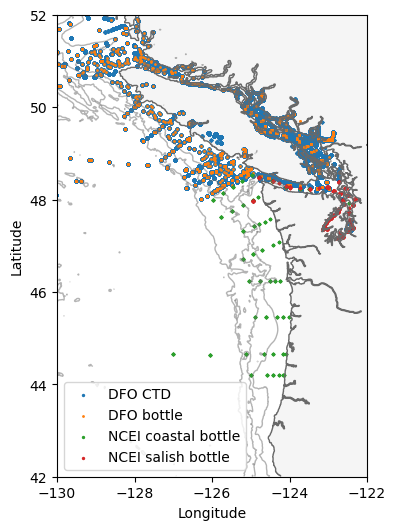

In [25]:
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
ax.scatter(ctd.lon, ctd.lat, s=2, label="DFO CTD")
ax.scatter(bot.lon, bot.lat, s=1, label="DFO bottle")
ax.scatter(nco.lon, nco.lat, s=2, label="NCEI coastal bottle")
ax.scatter(nsa.lon, nsa.lat, s=2, label="NCEI salish bottle")
ax.legend()


/tmp/ipykernel_149415/1873288718.py:5: UserWarning: linewidths is ignored by contourf
  ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')


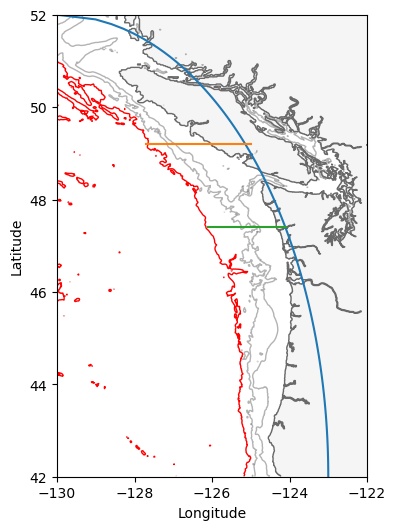

In [18]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')

fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[2000], colors='r')

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# salish sea cuttoff
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(10**2))*(7**2))-130
ax.plot(x,y)

#north cuttoff
ax.plot([-127.7,-125],[49.2,49.2])

# south cuttoff
ax.plot([-126.1,-124.1],[47.4,47.4])

In [56]:
ny = 49.2
sy = 47.4
d = 2000

# code for seperating observations into groups based on location and depth
def region(lat,lon,d):
    if d >= 2000:
        return 1 #offshore
    elif lon > np.sqrt((1-(((lat-42)**2)/(10**2)))*(7**2))-130 and lat < 51:
        return 2 #salish sea
    elif lat > ny:
        return 3 #north
    elif lat < sy:
        return 4 #south
    else:
        return 5 #domain


In [57]:
regions = ['Offshore', 'Salish Sea', 'North', 'South', 'Domain']
all['region'] = [region(all.lat[i],all.lon[i],all.h[i]) for i in range(len(all))]

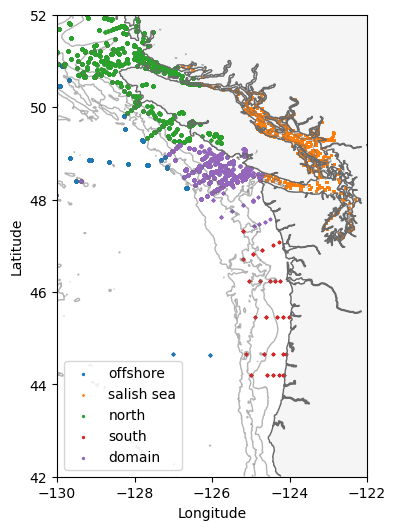

In [58]:
# quick visual check to see if seperated properly
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
ax.scatter(all.lon[all.region == 1], all.lat[all.region == 1], s=2, label="offshore")
ax.scatter(all.lon[all.region == 2], all.lat[all.region == 2], s=1, label="salish sea")
ax.scatter(all.lon[all.region == 3], all.lat[all.region == 3], s=2, label="north")
ax.scatter(all.lon[all.region == 4], all.lat[all.region == 4], s=2, label="south")
ax.scatter(all.lon[all.region == 5], all.lat[all.region == 5], s=2, label="domain")

ax.legend()

Evaluation of LiveOcean salinity compared to all DFO CTD casts (2017-2021) by region:


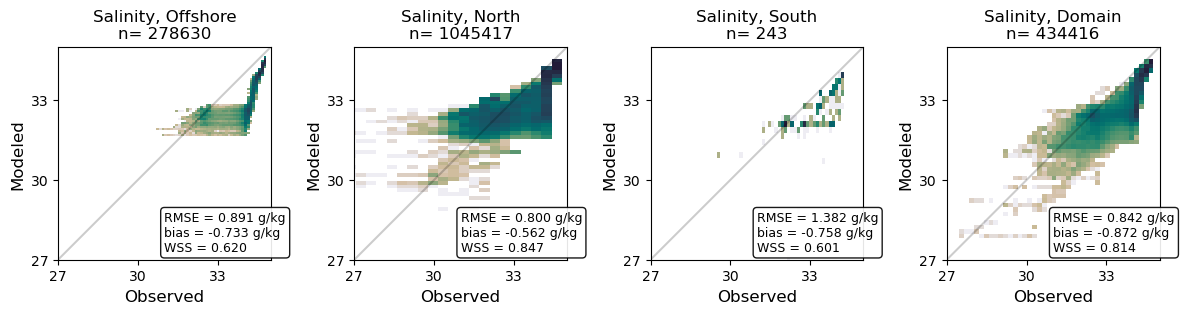

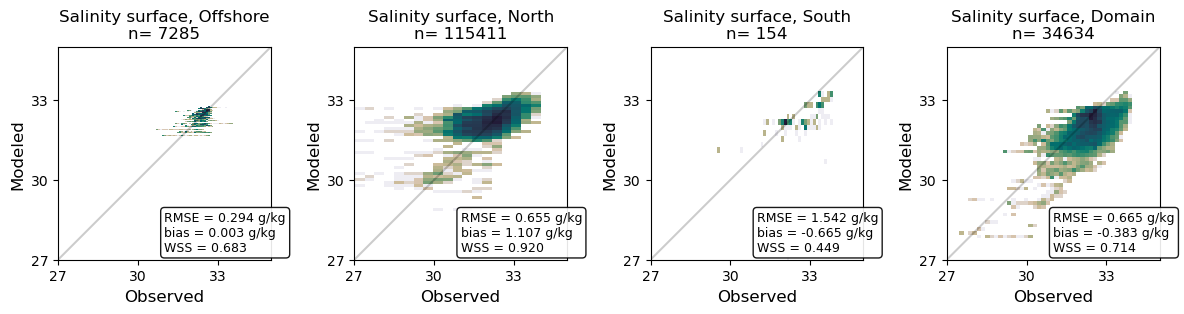

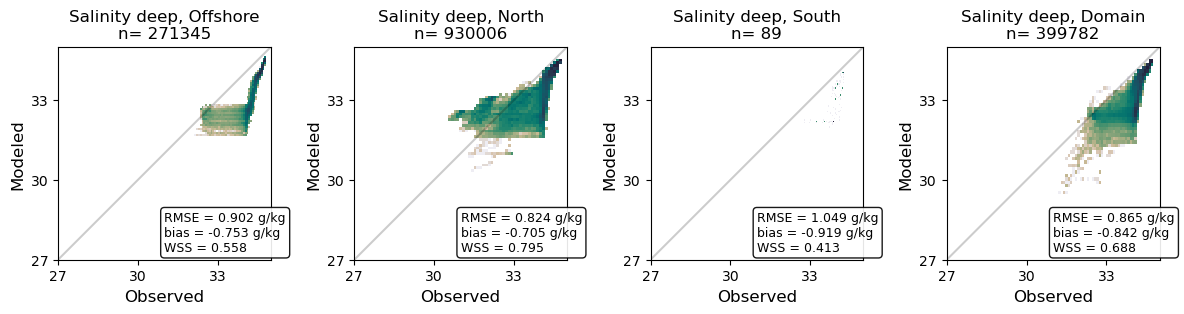

In [95]:
# evals of salinity by region
print("Evaluation of LiveOcean salinity compared to all DFO CTD casts (2017-2021) by region:")

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((27,35),(27,35),'k-',alpha=.2)

    iiS=(~np.isnan(all.SA[all.region == r]))&(~np.isnan(all.SA_model[all.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[all.region == r].loc[iiS,['SA']].values.flatten(),
                                        all[all.region == r].loc[iiS,['SA_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(27, 35, 3)
    axs[i].set_xlim((27,35))
    axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'Salinity, '+regions[r-1]+'\nn= '+str(len(all[all.region == r]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['SA'][all.region == r], all['SA_model'][all.region == r], (27,35), 'g/kg')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((27,35),(27,35),'k-',alpha=.2)

    iiS=(~np.isnan(all.SA[(all.region == r) & (all.z > d)]))&(~np.isnan(all.SA_model[(all.region == r) & (all.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r) & (all.z > d)].loc[iiS,['SA']].values.flatten(),
                                        all[(all.region == r) & (all.z > d)].loc[iiS,['SA_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(27, 35, 3)
    axs[i].set_xlim((27,35))
    axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'Salinity surface, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r) & (all.z > d)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['SA'][(all.region == r) & (all.z > d)], all['SA_model'][(all.region == r) & (all.z > d)], (27,35), 'g/kg')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((27,35),(27,35),'k-',alpha=.2)

    iiS=(~np.isnan(all.SA[(all.region == r) & (all.z <= d)]))&(~np.isnan(all.SA_model[(all.region == r) & (all.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r) & (all.z <= d)].loc[iiS,['SA']].values.flatten(),
                                        all[(all.region == r) & (all.z <= d)].loc[iiS,['SA_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(27, 35, 3)
    axs[i].set_xlim((27,35))
    axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'Salinity deep, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r) & (all.z <= d)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['SA'][(all.region == r) & (all.z <= d)], all['SA_model'][(all.region == r) & (all.z <= d)], (27,35), 'g/kg')

plt.tight_layout()


Evaluation of LiveOcean conservative temperature compared to all DFO CTD casts (2017-2021) by region:


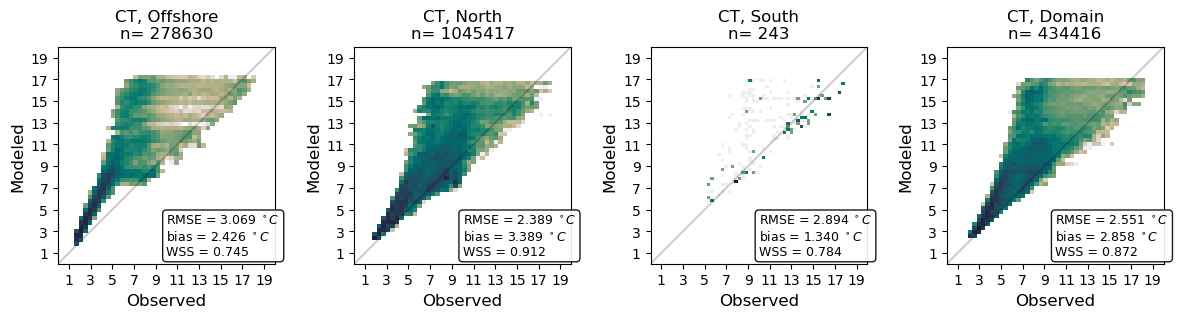

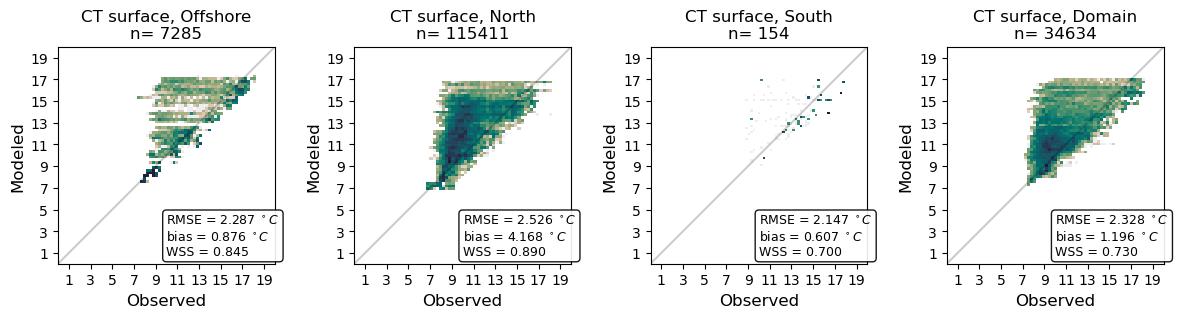

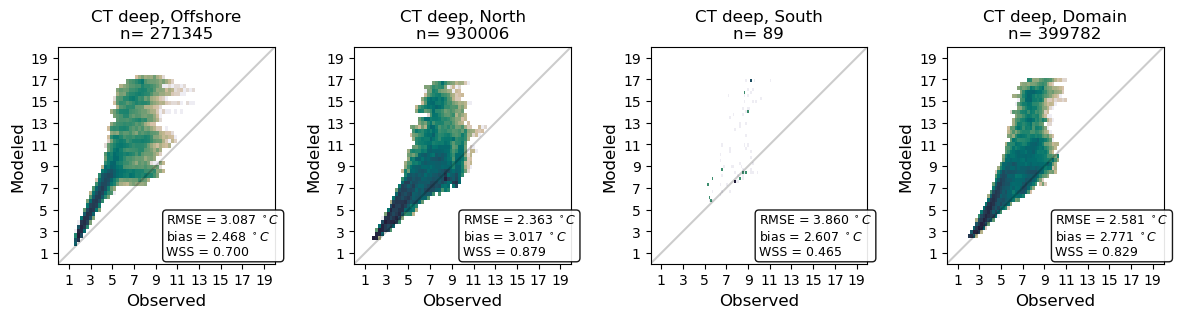

In [68]:
# evals of temperature by region
print("Evaluation of LiveOcean conservative temperature compared to all DFO CTD casts (2017-2021) by region:")

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((0,20),(0,20),'k-',alpha=.2)

    iiS=(~np.isnan(all.CT[all.region == r]))&(~np.isnan(all.CT_model[all.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[all.region == r].loc[iiS,['CT']].values.flatten(),
                                        all[all.region == r].loc[iiS,['CT_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(1, 21, 2)
    axs[i].set_xlim((0,20))
    axs[i].set_ylim((0,20))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'CT, '+regions[r-1]+'\nn= '+str(len(all[all.region == r]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['CT'][all.region == r], all['CT_model'][all.region == r], (0,20), '$^\circ C$')

plt.tight_layout()

#surface
d=-50

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((0,20),(0,20),'k-',alpha=.2)

    iiS=(~np.isnan(all.CT[(all.region == r) & (all.z > d)]))&(~np.isnan(all.CT_model[(all.region == r) & (all.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r) & (all.z > d)].loc[iiS,['CT']].values.flatten(),
                                        all[(all.region == r) & (all.z > d)].loc[iiS,['CT_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(1, 21, 2)
    axs[i].set_xlim((0,20))
    axs[i].set_ylim((0,20))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'CT surface, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r) & (all.z > d)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['CT'][(all.region == r) & (all.z >d)], all['CT_model'][(all.region == r) & (all.z > d)], (0,20), '$^\circ C$')

plt.tight_layout()

#deep

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((0,20),(0,20),'k-',alpha=.2)

    iiS=(~np.isnan(all.CT[(all.region == r) & (all.z <= d)]))&(~np.isnan(all.CT_model[(all.region == r) & (all.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r) & (all.z <= d)].loc[iiS,['CT']].values.flatten(),
                                        all[(all.region == r) & (all.z <= d)].loc[iiS,['CT_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(1, 21, 2)
    axs[i].set_xlim((0,20))
    axs[i].set_ylim((0,20))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'CT deep, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r) & (all.z <= d)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['CT'][(all.region == r) & (all.z <= d)], all['CT_model'][(all.region == r) & (all.z <= d)], (0,20), '$^\circ C$')

plt.tight_layout()

Evaluation of LiveOcean dissolved oxygen compared to all DFO CTD casts (2017-2021) by region:


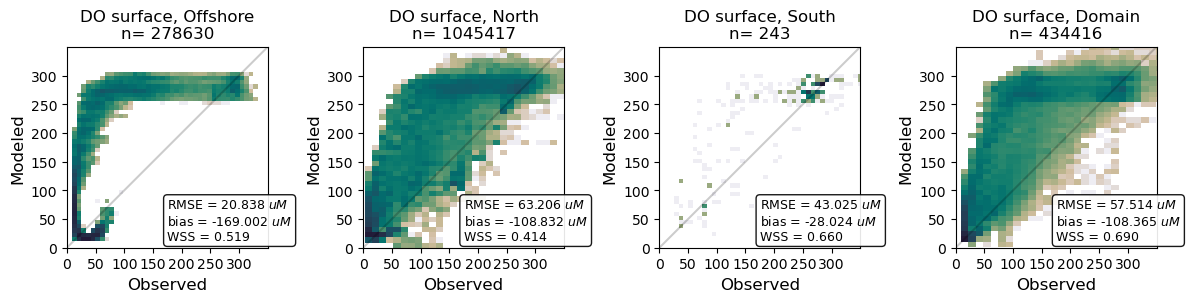

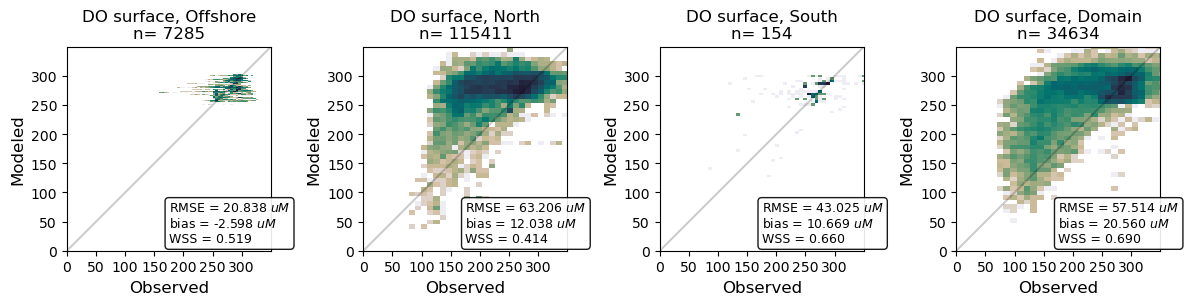

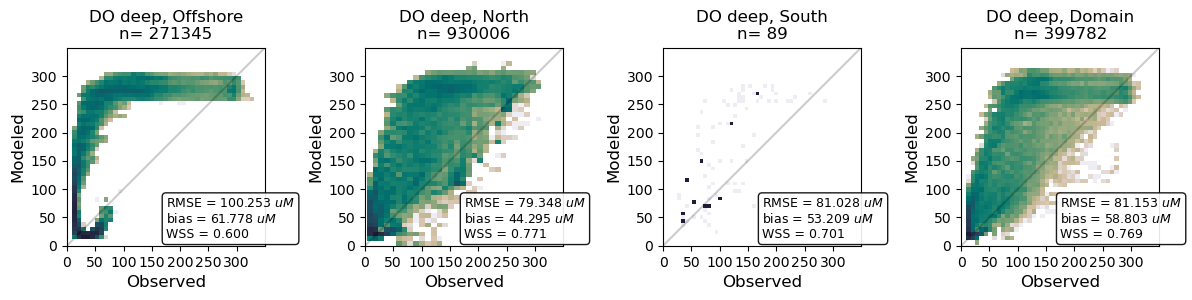

In [73]:
# evals of DO by region
print("Evaluation of LiveOcean dissolved oxygen compared to all DFO CTD casts (2017-2021) by region:")

cmap = cm.rain
cmap.set_extremes(under='w')

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((0,350),(0,350),'k-',alpha=.2)

    iiS=(~np.isnan(all['DO (uM)'][(all.region == r)]))&(~np.isnan(all.DO_model[(all.region == r)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r)].loc[iiS,['DO (uM)']].values.flatten(),
                                        all[(all.region == r)].loc[iiS,['DO_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(0,350, 50)
    axs[i].set_xlim((0,350))
    axs[i].set_ylim((0,350))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'DO surface, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['DO (uM)'][(all.region == r) & (all.z >d)], all['DO_model'][(all.region == r)], (0,350), '$uM$')

plt.tight_layout()


#surface
d=-50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((0,350),(0,350),'k-',alpha=.2)

    iiS=(~np.isnan(all['DO (uM)'][(all.region == r) & (all.z >d)]))&(~np.isnan(all.DO_model[(all.region == r) & (all.z >d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r) & (all.z >d)].loc[iiS,['DO (uM)']].values.flatten(),
                                        all[(all.region == r) & (all.z >d)].loc[iiS,['DO_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(0,350, 50)
    axs[i].set_xlim((0,350))
    axs[i].set_ylim((0,350))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'DO surface, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r) & (all.z >d)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['DO (uM)'][(all.region == r) & (all.z >d)], all['DO_model'][(all.region == r) & (all.z >d)], (0,350), '$uM$')

plt.tight_layout()

#deep 
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((0,350),(0,350),'k-',alpha=.2)

    iiS=(~np.isnan(all['DO (uM)'][(all.region == r) & (all.z <=d)]))&(~np.isnan(all.DO_model[(all.region == r) & (all.z <=d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(all[(all.region == r) & (all.z <=d)].loc[iiS,['DO (uM)']].values.flatten(),
                                        all[(all.region == r) & (all.z <=d)].loc[iiS,['DO_model']].values.flatten(),bins=40,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(0,350, 50)
    axs[i].set_xlim((0,350))
    axs[i].set_ylim((0,350))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'DO deep, '+regions[r-1]+'\nn= '+str(len(all[(all.region == r) & (all.z <=d)]))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], all['DO (uM)'][(all.region == r) & (all.z <=d)], all['DO_model'][(all.region == r) & (all.z <=d)], (0,350), '$uM$')

plt.tight_layout()




In [82]:
def prop_prop(ax,stringX,stringY,x,y,binX,binY):
    cmap = cm.rain
    cmap.set_bad('w')
    cmap.set_extremes(under='w')

    bins = [binX,binY]
    H, xedges, yedges=np.histogram2d(x,y,bins=bins)
    H = H.T
    H_final = np.where(H>0, H, H*np.nan)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=LogNorm(vmin=10, vmax=45000))
    ax.set_ylabel(stringY)
    ax.set_xlabel(stringX)


In [85]:
#set consistent bins
Tbin = np.linspace(0,20,100)
Sbin = np.linspace(25,37,100)
Dbin = np.linspace(0,350,100)

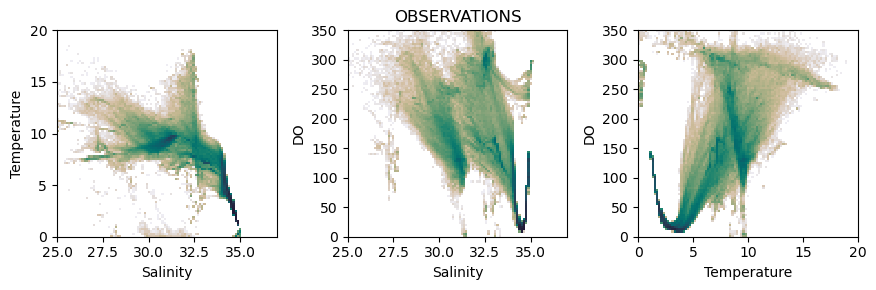

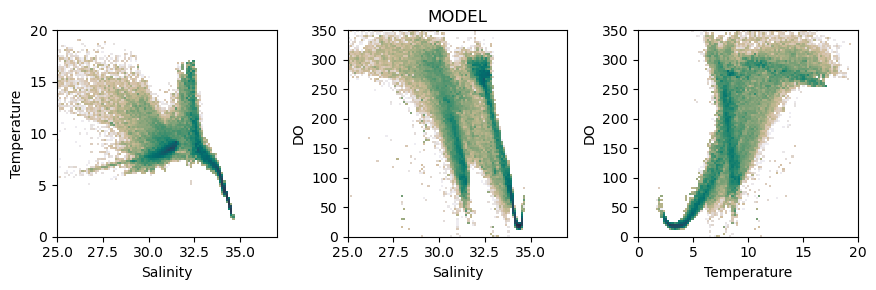

In [88]:
# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",all.SA,all.CT,Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA,all["DO (uM)"],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT,all["DO (uM)"],Tbin,Dbin)
axs[1].set_title('OBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",all.SA_model,all.CT_model,Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA_model,all.DO_model,Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT_model,all.DO_model,Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()


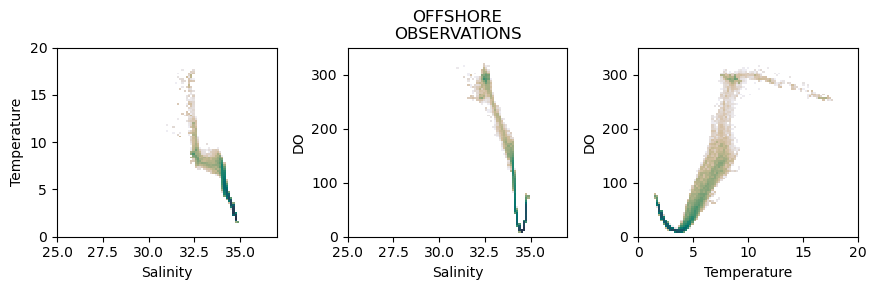

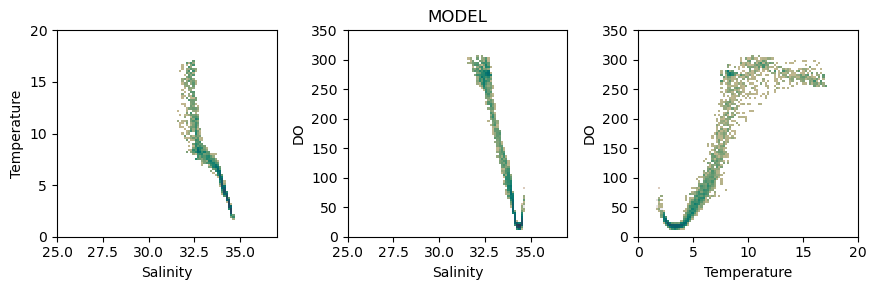

In [89]:
# same thing but by region
#OFFSHORE
r=1

# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",all.SA[all.region == r],all.CT[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA[all.region == r],all["DO (uM)"][all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT[all.region == r],all["DO (uM)"][all.region == r],Tbin,Dbin)
axs[1].set_title('OFFSHORE\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",all.SA_model[all.region == r],all.CT_model[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA_model[all.region == r],all.DO_model[all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT_model[all.region == r],all.DO_model[all.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

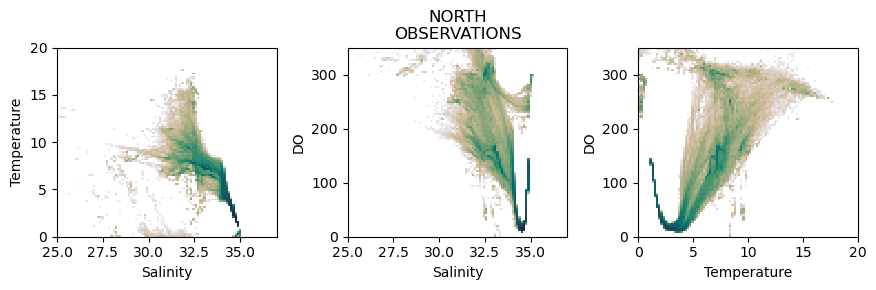

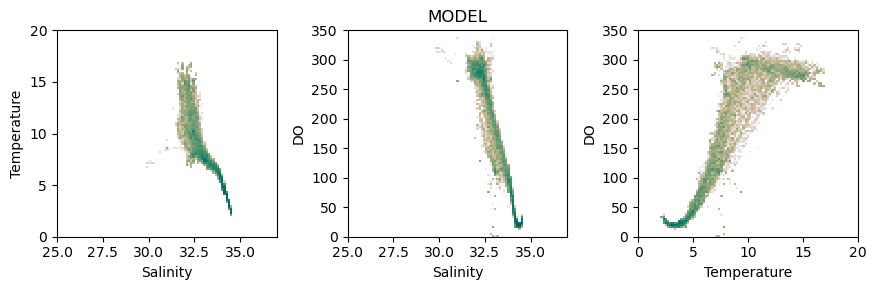

In [90]:
# same thing but by region
r=3
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",all.SA[all.region == r],all.CT[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA[all.region == r],all["DO (uM)"][all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT[all.region == r],all["DO (uM)"][all.region == r],Tbin,Dbin)
axs[1].set_title('NORTH\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",all.SA_model[all.region == r],all.CT_model[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA_model[all.region == r],all.DO_model[all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT_model[all.region == r],all.DO_model[all.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

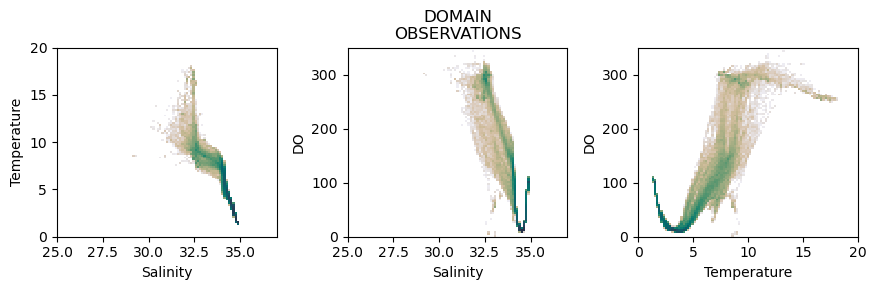

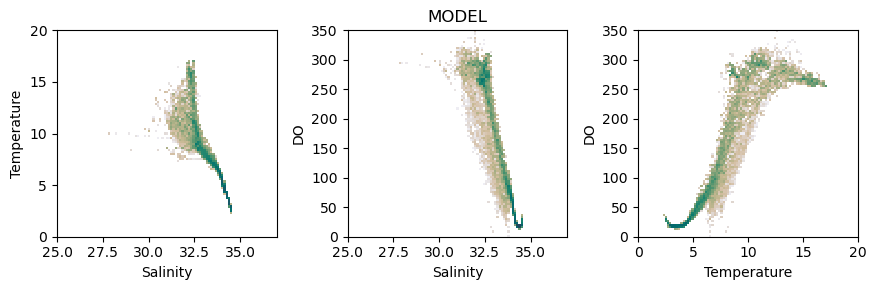

In [91]:
# same thing but by region
r=5
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",all.SA[all.region == r],all.CT[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA[all.region == r],all["DO (uM)"][all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT[all.region == r],all["DO (uM)"][all.region == r],Tbin,Dbin)
axs[1].set_title('DOMAIN\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",all.SA_model[all.region == r],all.CT_model[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA_model[all.region == r],all.DO_model[all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT_model[all.region == r],all.DO_model[all.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

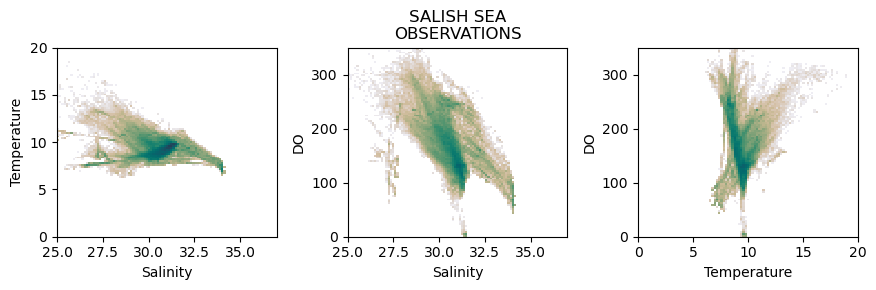

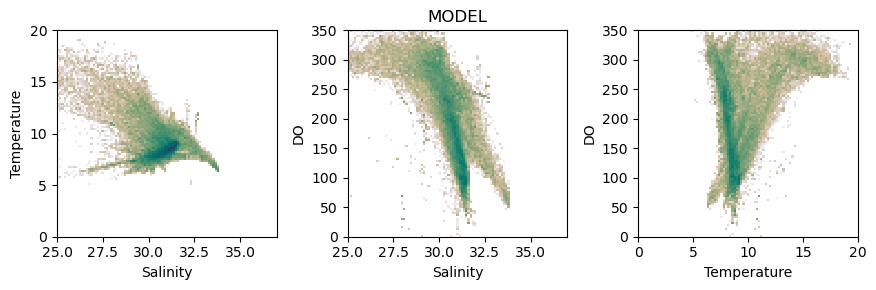

In [92]:
# same thing but by region
r=2
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",all.SA[all.region == r],all.CT[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA[all.region == r],all["DO (uM)"][all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT[all.region == r],all["DO (uM)"][all.region == r],Tbin,Dbin)
axs[1].set_title('SALISH SEA\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",all.SA_model[all.region == r],all.CT_model[all.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",all.SA_model[all.region == r],all.DO_model[all.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",all.CT_model[all.region == r],all.DO_model[all.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

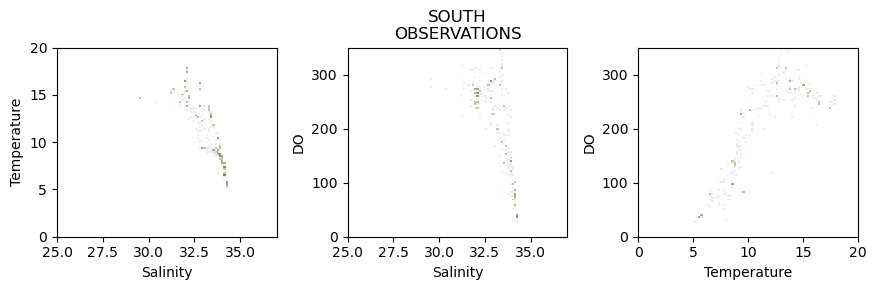

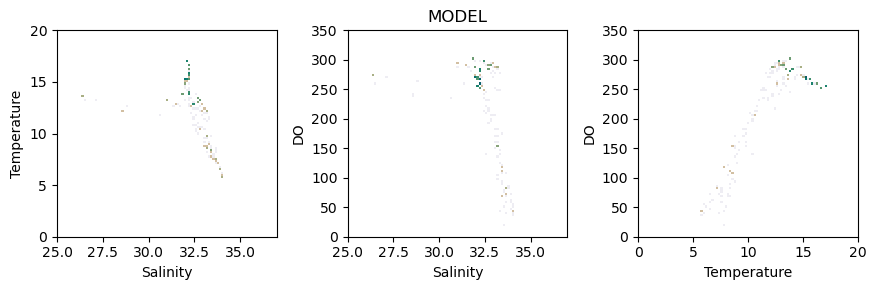

In [94]:
def prop_prop_south(ax,stringX,stringY,x,y,binX,binY):
    cmap = cm.rain
    cmap.set_bad('w')
    cmap.set_extremes(under='w')

    bins = [binX,binY]
    H, xedges, yedges=np.histogram2d(x,y,bins=bins)
    H = H.T
    H_final = np.where(H>0, H, H*np.nan)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=LogNorm(vmin=1, vmax=50))
    ax.set_ylabel(stringY)
    ax.set_xlabel(stringX)

# same thing but by region
r=4
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop_south(axs[0],"Salinity","Temperature",all.SA[all.region == r],all.CT[all.region == r],Sbin,Tbin)
prop_prop_south(axs[1],"Salinity","DO",all.SA[all.region == r],all["DO (uM)"][all.region == r],Sbin,Dbin)
prop_prop_south(axs[2],"Temperature","DO",all.CT[all.region == r],all["DO (uM)"][all.region == r],Tbin,Dbin)
axs[1].set_title('SOUTH\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop_south(axs[0],"Salinity","Temperature",all.SA_model[all.region == r],all.CT_model[all.region == r],Sbin,Tbin)
prop_prop_south(axs[1],"Salinity","DO",all.SA_model[all.region == r],all.DO_model[all.region == r],Sbin,Dbin)
prop_prop_south(axs[2],"Temperature","DO",all.CT_model[all.region == r],all.DO_model[all.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()